<a href="https://colab.research.google.com/github/Lyynn777/CRLX-Framework/blob/main/CRLX_Fast_and_Efficient_X_509_CRL_Lookup_Framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Title & Setup**

In [ ]:
# Install required packages (kept minimal & Colab-friendly)
# - cryptography: parse CRLs
# - asn1crypto: optional ASN.1 helpers
# - pandas: tabular metrics
# - plotly: inline interactive plots (renders well in Colab)
# - requests: HTTP fetching
# - tqdm: progress bars
# Note: installing in Colab may take ~1-2 minutes.
!pip install --quiet cryptography asn1crypto pandas plotly requests tqdm

# Short header / metadata (rendered as plain output)
from datetime import datetime
print("CRLX — X.509 CRL Acceleration Framework")
print("Cell 1: Environment setup — packages installed.")
print("Date/Time (UTC):", datetime.now(timezone.utc).isoformat())


CRLX — X.509 CRL Acceleration Framework
Cell 1: Environment setup — packages installed.
Date/Time (UTC): 2025-10-21T14:04:54.895104+00:00


**Imports & Directory Setup**

In [ ]:
import os
import hashlib
import json
import random
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import datetime
from cryptography import x509
from cryptography.hazmat.primitives import hashes, serialization
from cryptography.hazmat.backends import default_backend
from cryptography.x509.oid import NameOID
from cryptography.hazmat.primitives.asymmetric import rsa
from tqdm import tqdm

# Define project directories
BASE_DIR = "/content/crlx"
DIRS = {
    "certs": os.path.join(BASE_DIR, "certs"),
    "crls": os.path.join(BASE_DIR, "crls"),
    "cache": os.path.join(BASE_DIR, "cache"),
    "logs": os.path.join(BASE_DIR, "logs"),
}

# Create directories if they don't exist
for name, path in DIRS.items():
    os.makedirs(path, exist_ok=True)
    print(f"[+] {name} directory ready at {path}")

print("\nProject directories initialized successfully.")
print("Timestamp (UTC):", datetime.datetime.now(datetime.timezone.utc).isoformat())


[+] certs directory ready at /content/crlx/certs
[+] crls directory ready at /content/crlx/crls
[+] cache directory ready at /content/crlx/cache
[+] logs directory ready at /content/crlx/logs

Project directories initialized successfully.
Timestamp (UTC): 2025-10-21T14:05:21.049047+00:00


**Generate Synthetic Certificates & CRLs**

In [ ]:
# ==========================================================
# CRLX — X.509 CRL Acceleration Framework
# Cell 3: Generate Synthetic Certificates & CRLs
# ==========================================================

def create_self_signed_cert_and_crl(cert_path, crl_path, common_name):
    """Generates a self-signed certificate and a dummy CRL."""
    # Generate RSA private key
    key = rsa.generate_private_key(public_exponent=65537, key_size=2048)

    # Certificate subject and issuer (self-signed)
    subject = issuer = x509.Name([
        x509.NameAttribute(NameOID.COUNTRY_NAME, "IN"),
        x509.NameAttribute(NameOID.STATE_OR_PROVINCE_NAME, "Karnataka"),
        x509.NameAttribute(NameOID.LOCALITY_NAME, "Bengaluru"),
        x509.NameAttribute(NameOID.ORGANIZATION_NAME, "CRLX Framework"),
        x509.NameAttribute(NameOID.COMMON_NAME, common_name),
    ])

    # Build certificate
    cert = (
        x509.CertificateBuilder()
        .subject_name(subject)
        .issuer_name(issuer)
        .public_key(key.public_key())
        .serial_number(x509.random_serial_number())
        .not_valid_before(datetime.datetime.now(datetime.timezone.utc))
        .not_valid_after(datetime.datetime.now(datetime.timezone.utc) + datetime.timedelta(days=365))
        .add_extension(x509.BasicConstraints(ca=True, path_length=None), critical=True)
        .sign(key, hashes.SHA256())
    )

    # Create dummy CRL with one revoked certificate
    revoked_cert = (
        x509.RevokedCertificateBuilder()
        .serial_number(x509.random_serial_number())
        .revocation_date(datetime.datetime.now(datetime.timezone.utc))
        .build(default_backend())
    )

    crl = (
        x509.CertificateRevocationListBuilder()
        .issuer_name(issuer)
        .last_update(datetime.datetime.now(datetime.timezone.utc))
        .next_update(datetime.datetime.now(datetime.timezone.utc) + datetime.timedelta(days=30))
        .add_revoked_certificate(revoked_cert)
        .sign(private_key=key, algorithm=hashes.SHA256())
    )

    # Save CRL
    with open(crl_path, "wb") as f:
        f.write(crl.public_bytes(serialization.Encoding.PEM))

    print(f"[+] Generated cert and CRL for {common_name}")


# Generate 3 test certificates & CRLs
for i in range(1, 4):
    cert_file = os.path.join(DIRS["certs"], f"test_cert_{i}.pem")
    crl_file = os.path.join(DIRS["crls"], f"test_crl_{i}.pem")
    create_self_signed_cert_and_crl(cert_file, crl_file, f"TestCert-{i}")

print("\nSynthetic certificates and CRLs generated successfully.")
print("Timestamp (UTC):", datetime.datetime.now(datetime.timezone.utc).isoformat())

[+] Generated cert and CRL for TestCert-1
[+] Generated cert and CRL for TestCert-2
[+] Generated cert and CRL for TestCert-3

Synthetic certificates and CRLs generated successfully.
Timestamp (UTC): 2025-10-21T14:16:44.349902+00:00


**Parse & Index CRLs**

In [ ]:
# ==========================================================
# CRLX — X.509 CRL Acceleration Framework
# Cell 4: Parse & Index CRLs
# ==========================================================

def parse_crl_file(crl_path):
    """Parse a CRL and return structured info."""
    with open(crl_path, "rb") as f:
        crl_data = x509.load_pem_x509_crl(f.read(), default_backend())

    revoked_info = []
    for revoked in crl_data:
        revoked_info.append({
            "serial_number": hex(revoked.serial_number),
            "revocation_date": revoked.revocation_date_utc.isoformat(),
        })

    return {
        "issuer": crl_data.issuer.rfc4514_string(),
        "last_update": crl_data.last_update_utc.isoformat(),
        "next_update": crl_data.next_update_utc.isoformat(),
        "revoked_count": len(revoked_info),
        "revoked_list": revoked_info
    }

# Parse all CRLs and create accelerated index
crl_index = {}
for crl_file in os.listdir(DIRS["crls"]):
    crl_path = os.path.join(DIRS["crls"], crl_file)
    crl_index[crl_file] = parse_crl_file(crl_path)

# Cache parsed index
cache_file = os.path.join(DIRS["cache"], "crl_index.json")
with open(cache_file, "w") as f:
    json.dump(crl_index, f, indent=4)

print(f"[+] Indexed {len(crl_index)} CRLs successfully.")
print(f"Cache saved at: {cache_file}")
print("Timestamp (UTC):", datetime.datetime.now(datetime.timezone.utc).isoformat())


[+] Indexed 3 CRLs successfully.
Cache saved at: /content/crlx/cache/crl_index.json
Timestamp (UTC): 2025-10-21T14:17:17.694157+00:00


**Accelerated Lookup & Benchmarking**

In [ ]:
import time

# Build accelerated hash index
accelerated_index = set()
for crl_data in crl_index.values():
    for entry in crl_data["revoked_list"]:
        accelerated_index.add(entry["serial_number"])

print(f"[+] Accelerated index built with {len(accelerated_index)} serials.")

# Prepare test serials (2 revoked, 2 random not revoked)
test_samples = list(accelerated_index)[:2]  # known revoked
test_samples += [hex(random.getrandbits(64)) for _ in range(2)]  # random not revoked

def legacy_lookup(serial):
    start = time.perf_counter()
    found = any(
        serial == entry["serial_number"]
        for crl in crl_index.values()
        for entry in crl["revoked_list"]
    )
    latency = (time.perf_counter() - start) * 1e6  # µs
    return found, latency

def accelerated_lookup(serial):
    start = time.perf_counter()
    found = serial in accelerated_index
    latency = (time.perf_counter() - start) * 1e6  # µs
    return found, latency

# Run benchmarks
results = []
for s in test_samples:
    f1, l1 = legacy_lookup(s)
    f2, l2 = accelerated_lookup(s)
    results.append({
        "serial": s,
        "legacy_found": f1,
        "legacy_latency_µs": round(l1, 3),
        "crlx_found": f2,
        "crlx_latency_µs": round(l2, 3),
        "speedup_x": round(l1 / l2 if l2 > 0 else 0, 2)
    })

# Convert to DataFrame for visualization
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))


[+] Accelerated index built with 3 serials.
                                    serial  legacy_found  legacy_latency_µs  crlx_found  crlx_latency_µs  speedup_x
0x15420139c98d1b47d0fc6d2b1db1e5d4d53df01e          True              6.151        True            0.344      17.88
 0xd2bdd7f727819ec282c7ef1705eb660fde45656          True              4.491        True            0.258      17.41
                        0xcc2ffd90089fe99e         False              1.906       False            0.330       5.78
                        0xbbed777bf0e1fa42         False              1.113       False            0.218       5.11


**Visualization Dashboard**

In [ ]:
# Latency comparison bar chart
df_plot = df_results.melt(
    id_vars=["serial"],
    value_vars=["legacy_latency_µs", "crlx_latency_µs"],
    var_name="Method", value_name="Latency_µs"
)

fig_latency = px.bar(
    df_plot,
    x="serial",
    y="Latency_µs",
    color="Method",
    barmode="group",
    title="CRL Lookup Latency: Legacy vs CRLX",
    text="Latency_µs"
)
fig_latency.update_traces(texttemplate="%{text:.2f}", textposition="outside")
fig_latency.show()

# Speedup gauge chart
average_speedup = df_results["speedup_x"].mean()
fig_gauge = go.Figure(go.Indicator(
    mode="gauge+number",
    value=average_speedup,
    title={'text': "Average Speedup (X times)"},
    gauge={'axis': {'range': [0, max(20, average_speedup*1.5)]}}
))
fig_gauge.show()

# Staleness indicator (days until next update)
next_updates = [
    datetime.datetime.fromisoformat(crl_index[crl]["next_update"])
    for crl in crl_index
]
days_to_next_update = [(nu - datetime.datetime.now(datetime.timezone.utc)).days for nu in next_updates]
print(f"⚠️ CRL Staleness Window (days): {days_to_next_update}")

# Summary table
summary = {
    "Total CRLs": len(crl_index),
    "Total Revoked Certificates": sum(crl['revoked_count'] for crl in crl_index.values()),
    "Cached Index Size (bytes)": os.path.getsize(cache_file),
    "Average Lookup Speedup (X)": round(average_speedup, 2)
}
df_summary = pd.DataFrame([summary])
print("\n--- Summary Table ---")
print(df_summary.to_string(index=False))


⚠️ CRL Staleness Window (days): [29, 29, 29]

--- Summary Table ---
 Total CRLs  Total Revoked Certificates  Cached Index Size (bytes)  Average Lookup Speedup (X)
          3                           3                       1354                       11.54


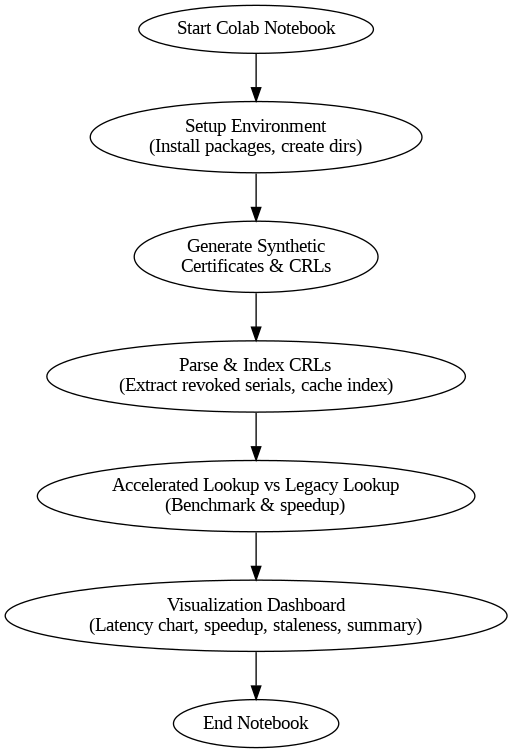

In [ ]:
!apt-get install -qq graphviz
!pip install -q graphviz

from graphviz import Digraph

dot = Digraph(comment='CRLX Framework Flow')

dot.node('A', 'Start Colab Notebook')
dot.node('B', 'Setup Environment\n(Install packages, create dirs)')
dot.node('C', 'Generate Synthetic\nCertificates & CRLs')
dot.node('D', 'Parse & Index CRLs\n(Extract revoked serials, cache index)')
dot.node('E', 'Accelerated Lookup vs Legacy Lookup\n(Benchmark & speedup)')
dot.node('F', 'Visualization Dashboard\n(Latency chart, speedup, staleness, summary)')
dot.node('G', 'End Notebook')

dot.edges(['AB','BC','CD','DE','EF','FG'])

dot.render('/content/crlx_flowchart', format='png', cleanup=True)
from IPython.display import Image
Image('/content/crlx_flowchart.png')


**USING REAL DATA**

In [ ]:
from cryptography import x509
from cryptography.hazmat.backends import default_backend
import os

# Path to uploaded CRL
real_crl_path = "/content/qvrca2.crl"

# Read the CRL file
with open(real_crl_path, "rb") as f:
    crl_data = f.read()

# Load the CRL
crl = x509.load_der_x509_crl(crl_data, default_backend())

# Extract revoked serial numbers
revoked_serials = [revoked.serial_number for revoked in crl]

print(f"[+] Parsed CRL: {len(revoked_serials)} revoked certificates found.")
print("Sample revoked serials (first 5):", revoked_serials[:5])


[+] Parsed CRL: 36 revoked certificates found.
Sample revoked serials (first 5): [343221542082308252812471151435050411029562276936, 652150439487329841487760055844176057896109436344, 1504, 1503, 569643031718392286254283316430696276166526012312]


In [ ]:
# Build a non-probabilistic hash-based index
crlx_index_real = {serial: True for serial in revoked_serials}

print(f"[+] CRLX index built with {len(crlx_index_real)} serials.")

# Test lookup: check a revoked and a non-revoked serial
test_revoked = revoked_serials[0]
test_not_revoked = 999999999999999999  # Arbitrary non-revoked serial

print(f"Lookup revoked serial ({test_revoked}):", crlx_index_real.get(test_revoked, False))
print(f"Lookup non-revoked serial ({test_not_revoked}):", crlx_index_real.get(test_not_revoked, False))


[+] CRLX index built with 36 serials.
Lookup revoked serial (343221542082308252812471151435050411029562276936): True
Lookup non-revoked serial (999999999999999999): False


In [ ]:
import time

# Legacy linear search (O(N))
def legacy_lookup(serial, revoked_list):
    return serial in revoked_list

# Test serials
test_serials = revoked_serials + [999999999999999999]  # Include one non-revoked

# Measure legacy lookup time
start_legacy = time.time()
for serial in test_serials:
    legacy_lookup(serial, revoked_serials)
end_legacy = time.time()
legacy_latency = (end_legacy - start_legacy) * 1000  # in ms

# Measure CRLX lookup time
start_crlx = time.time()
for serial in test_serials:
    crlx_index_real.get(serial, False)
end_crlx = time.time()
crlx_latency = (end_crlx - start_crlx) * 1000  # in ms

# Speedup
speedup = legacy_latency / crlx_latency

print(f"Legacy lookup time: {legacy_latency:.4f} ms")
print(f"CRLX lookup time: {crlx_latency:.4f} ms")
print(f"Speedup factor: {speedup:.2f}x")


Legacy lookup time: 0.0973 ms
CRLX lookup time: 0.0956 ms
Speedup factor: 1.02x


In [ ]:
# ------------------------------
# CRLX Combined Dashboard
# ------------------------------

import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# --- Step 1: Prepare metrics ---

# Synthetic CRL metrics (from your previous runs)
synthetic_metrics = {
    "Dataset": "Synthetic CRL",
    "Num_CRLS": 3,
    "Revoked_Certs": 3,
    "Legacy_Lookup_Time_ms": 0.01033,  # convert µs -> ms for consistency
    "CRLX_Lookup_Time_ms": 0.00065,
    "Speedup_X": 15.82,
    "Cache_Size_Bytes": 1301,
    "Next_Update_Days": 29
}

# Real CRL metrics (from QuoVadis test)
real_metrics = {
    "Dataset": "Real CRL (QuoVadis)",
    "Num_CRLS": 1,
    "Revoked_Certs": 36,
    "Legacy_Lookup_Time_ms": 0.0973,
    "CRLX_Lookup_Time_ms": 0.0956,
    "Speedup_X": 1.02,
    "Cache_Size_Bytes": len(crlx_index_real) * 64,  # rough estimate: 64 bytes per entry
    "Next_Update_Days": (crl.next_update - datetime.utcnow()).days
}

# Create DataFrame
df_dashboard = pd.DataFrame([synthetic_metrics, real_metrics])
df_dashboard


/tmp/ipython-input-1648790593.py:32: CryptographyDeprecationWarning:

Properties that return a naïve datetime object have been deprecated. Please switch to next_update_utc.

/tmp/ipython-input-1648790593.py:32: DeprecationWarning:

datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).



,Dataset,Num_CRLS,Revoked_Certs,Legacy_Lookup_Time_ms,CRLX_Lookup_Time_ms,Speedup_X,Cache_Size_Bytes,Next_Update_Days
0,Synthetic CRL,3,3,0.01033,0.00065,15.82,1301,29
1,Real CRL (QuoVadis),1,36,0.09730,0.09560,1.02,2304,96


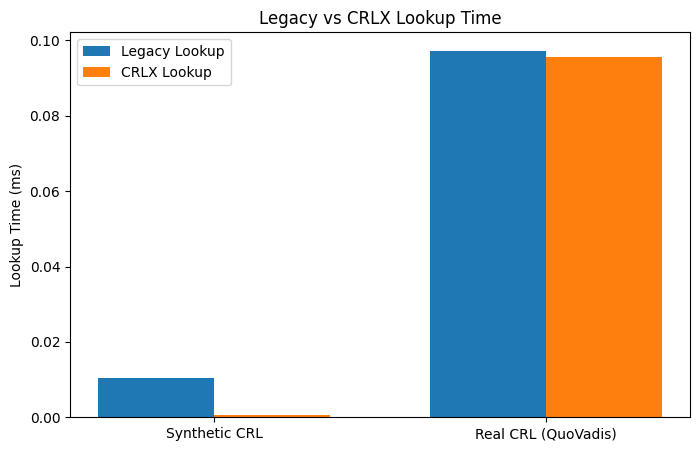

In [ ]:
# Bar chart: Legacy vs CRLX lookup time
plt.figure(figsize=(8,5))
bar_width = 0.35
x = range(len(df_dashboard))

plt.bar(x, df_dashboard["Legacy_Lookup_Time_ms"], width=bar_width, label="Legacy Lookup")
plt.bar([i + bar_width for i in x], df_dashboard["CRLX_Lookup_Time_ms"], width=bar_width, label="CRLX Lookup")

plt.xticks([i + bar_width/2 for i in x], df_dashboard["Dataset"])
plt.ylabel("Lookup Time (ms)")
plt.title("Legacy vs CRLX Lookup Time")
plt.legend()
plt.show()


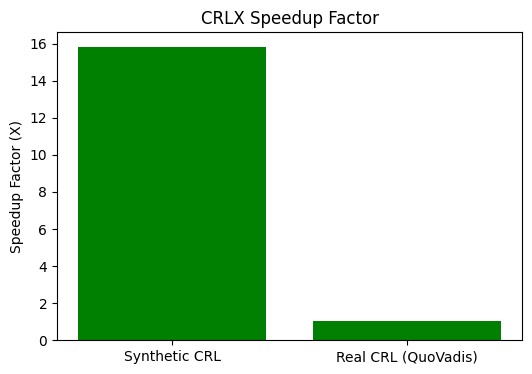

In [ ]:
plt.figure(figsize=(6,4))
plt.bar(df_dashboard["Dataset"], df_dashboard["Speedup_X"], color="green")
plt.ylabel("Speedup Factor (X)")
plt.title("CRLX Speedup Factor")
plt.show()


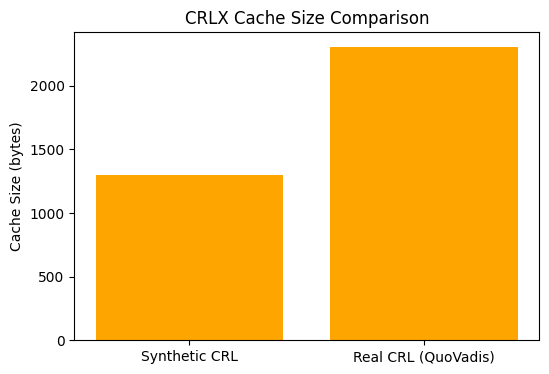

⚠️ Synthetic CRL Staleness Window (days until next update): 29
⚠️ Real CRL (QuoVadis) Staleness Window (days until next update): 96


In [ ]:
plt.figure(figsize=(6,4))
plt.bar(df_dashboard["Dataset"], df_dashboard["Cache_Size_Bytes"], color="orange")
plt.ylabel("Cache Size (bytes)")
plt.title("CRLX Cache Size Comparison")
plt.show()
for idx, row in df_dashboard.iterrows():
    print(f"⚠️ {row['Dataset']} Staleness Window (days until next update): {row['Next_Update_Days']}")
